# Шаг 1. Получение и парсинг данных

In [1]:
import requests
from bs4 import BeautifulSoup
from bs4.element import Comment
import pandas as pd
import datetime
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import gc
from sklearn.preprocessing import label_binarize

In [2]:
cookies = {
    '__ddg1_': 'peYZRM5tlNWPgugd940V',
    '__ddg9_': '92.243.182.237',
    '_ym_uid': '1715004481699210864',
    '_ym_d': '1730388353',
    '_ym_isad': '1',
    '_ym_visorc': 'w',
    'accept': '1',
    'ASPNET_SessionID': 'haizcalavgerqkaig0w12awe',
    '__ddg10_': '1730388981',
    '__ddg8_': 'jrQSy3NYA2gFDIsY',
}

In [3]:
headers = {
    'accept': 'text/html, */*; q=0.01',
    'accept-language': 'ru-RU,ru;q=0.9,en-US;q=0.8,en;q=0.7',
    'priority': 'u=1, i',
    'referer': 'https://www.cbr.ru/dkp/mp_dec/',
    'sec-ch-ua': '"Chromium";v="130", "Google Chrome";v="130", "Not?A_Brand";v="99"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"macOS"',
    'sec-fetch-dest': 'empty',
    'sec-fetch-mode': 'cors',
    'sec-fetch-site': 'same-origin',
    'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/130.0.0.0 Safari/537.36',
    'x-requested-with': 'XMLHttpRequest',
}


In [4]:
press_list = []
load_more_url = 'https://www.cbr.ru/Crosscut/NewsList/LoadMore/84035'
press_release_links = []

offset = 0
max_offset = 200

while offset < max_offset:
    params = {
        'intOffset': '0',
        'extOffset': str(offset),
    }
    response = requests.get(load_more_url, params=params)
    soup = BeautifulSoup(response.text, 'html.parser')
    hrefs = soup.find_all("div", {"class": "previews_item-title"})

    for href in hrefs:
        a_tag = href.find('a', href=True)
        if a_tag and a_tag['href'] not in press_release_links:
            press_release_links.append(a_tag['href'])

    offset += 10

for url in press_release_links:
    print('opening...' + url)
    response = requests.get('https://www.cbr.ru/' + url)
    bs = BeautifulSoup(response.text, 'html.parser')
    date = bs.find("div",{'class': 'col-md-6 col-12 news-info-line_date'}).get_text()
    text = bs.find_all("div", {"class": "landing-text"})
    press_list.append([date, text[0].get_text()])

opening.../press/pr/?file=25042025_133000key.htm
opening.../press/pr/?file=21032025_133000key.htm
opening.../press/pr/?file=14022025_133000key.htm
opening.../press/pr/?file=20122024_133000key.htm
opening.../press/pr/?file=25102024_133000Key.htm
opening.../press/pr/?file=13092024_133000Key.htm
opening.../press/pr/?file=26072024_133000Key.htm
opening.../press/pr/?file=07062024_133000Key.htm
opening.../press/pr/?file=26042024_133000key.htm
opening.../press/pr/?file=22032024_133000key.htm
opening.../press/pr/?file=16022024_133000key.htm
opening.../press/pr/?file=15122023_133000key.htm
opening.../press/pr/?file=27102023_133000key.htm
opening.../press/pr/?file=15092023_133000Key.htm
opening.../press/pr/?file=15082023_103000Key.htm
opening.../press/pr/?file=21072023_133000Key.htm
opening.../press/pr/?file=09062023_133024Key.htm
opening.../press/pr/?file=28042023_133000Key.htm
opening.../press/pr/?file=17032023_133000Key.htm
opening.../press/pr/?file=10022023_133000Key.htm
opening.../press/pr/

In [5]:
# формирование датафрейма
row_data = pd.DataFrame(press_list, columns = ['date', 'text'])
row_data = row_data.drop_duplicates()
row_data

,date,text
0,25 апреля 2025 года,\n \nСовет директоров Банка России 25 апреля 2...
1,21 марта 2025 года,\n \nСовет директоров Банка России 21 марта 20...
2,14 февраля 2025 года,\n \nСовет директоров Банка России 14 февраля ...
3,20 декабря 2024 года,\n \nСовет директоров Банка России 20 декабря ...
4,25 октября 2024 года,\n \nСовет директоров Банка России 25 октября ...
...,...,...
100,13 декабря 2013 года,\nСовет директоров Банка России 13 декабря 201...
101,8 ноября 2013 года,\nСовет директоров Банка России 8 ноября 2013 ...
102,14 октября 2013 года,"\nПресс-служба Банка России сообщает, что Сове..."
103,13 сентября 2013 года,\n О системе процентных инструментов денежно...


In [6]:
# чистим от лишних символов
def edit(df, column_name):
    df[column_name] = df[column_name].replace('\xa0', ' ', regex=True)
    df[column_name] = df[column_name].replace(r'\n', '', regex=True)
    df[column_name] = df[column_name].replace('_x000D_', '', regex=True)
    df[column_name] = df[column_name].replace('\r', ' ', regex=True)
    df[column_name] = df[column_name].apply(lambda x: x.strip())
    df[column_name] = df[column_name].replace('  ', ' ', regex=True)

    return df

edited_data = edit(row_data, 'text')

In [7]:
# убираем неинформативные пресс-релизы
import re

def remove_trash(df, column_name):

    mask = ~(df[column_name].str.contains("Банк России, следуя наилучшим практикам распространения данных", na=False) |
             df[column_name].str.contains("целях оперативного информирования пользователей", na=False) |
             df[column_name].str.contains("Банк России начинает публиковать на", na=False))

    filtered_df = df[mask]

    return filtered_df

filtered_df = remove_trash(edited_data, 'text')

In [8]:
# парсим дату
def parse_date(df, column_name):

    month_dict = {
        "января": 1, "февраля": 2, "марта": 3, "апреля": 4, "мая": 5, "июня": 6,
        "июля": 7, "августа": 8, "сентября": 9, "октября": 10, "ноября": 11,
        "декабря": 12
    }

    def extract_date_parts(date_str):
        try:
            match = re.match(r"(\d{1,2})\s+([а-я]+)\s+(\d{4})\s+года", date_str)
            if match:
                day = int(match.group(1))
                month = month_dict[match.group(2)]
                year = int(match.group(3))
                return year, month, day
            else:
                return None, None, None
        except (KeyError, AttributeError, ValueError):
            return None, None, None


    df[["year", "month", "day"]] = df[column_name].apply(
        lambda x: pd.Series(extract_date_parts(x))
    )

    return df.drop(columns=column_name)

df = parse_date(filtered_df, 'date')

In [9]:
# формируем колонку target
def classify_key_rate_change_df(df, column_name):

    target_values = []

    for text in df[column_name]:
        match = re.search(r"(повысить|понизить|снизить|сохранить|оставить)\s+(ключевую|процентную)\s+ставку", text.lower())
        if match:
            action = match.group(1)
            if action == "повысить":
                target_values.append(1)
            elif action == "понизить" or action == "снизить":
                target_values.append(-1)
            elif action == "сохранить" or action == "оставить":
                target_values.append(0)
        else:
            target_values.append("Не найдено")

    df['target'] = target_values
    return df


df = classify_key_rate_change_df(df, 'text')

In [10]:
df.reset_index(inplace=True)

In [11]:
df.loc[87, ['target']] = 1
df = df.drop(100).reset_index(drop=True)
df

,index,text,year,month,day,target
0,0,Совет директоров Банка России 25 апреля 2025 г...,2025,4,25,0
1,1,Совет директоров Банка России 21 марта 2025 го...,2025,3,21,0
2,2,Совет директоров Банка России 14 февраля 2025 ...,2025,2,14,0
3,3,Совет директоров Банка России 20 декабря 2024 ...,2024,12,20,0
4,4,Совет директоров Банка России 25 октября 2024 ...,2024,10,25,1
...,...,...,...,...,...,...
96,99,Совет директоров Банка России 14 февраля 2014 ...,2014,2,14,0
97,100,Совет директоров Банка России 13 декабря 2013 ...,2013,12,13,0
98,101,Совет директоров Банка России 8 ноября 2013 го...,2013,11,8,0
99,102,"Пресс-служба Банка России сообщает, что Совет ...",2013,10,14,0


In [12]:
import numpy as np
df['target'] = df['target'].shift(1)
df.loc[0, ['target']] = np.nan
df = df.drop(columns='index')
df.head()

,text,year,month,day,target
0,Совет директоров Банка России 25 апреля 2025 г...,2025,4,25,NaN
1,Совет директоров Банка России 21 марта 2025 го...,2025,3,21,0
2,Совет директоров Банка России 14 февраля 2025 ...,2025,2,14,0
3,Совет директоров Банка России 20 декабря 2024 ...,2024,12,20,0
4,Совет директоров Банка России 25 октября 2024 ...,2024,10,25,0


In [13]:
df = df.drop(0).reset_index(drop=True)
df.head()

,text,year,month,day,target
0,Совет директоров Банка России 21 марта 2025 го...,2025,3,21,0
1,Совет директоров Банка России 14 февраля 2025 ...,2025,2,14,0
2,Совет директоров Банка России 20 декабря 2024 ...,2024,12,20,0
3,Совет директоров Банка России 25 октября 2024 ...,2024,10,25,0
4,Совет директоров Банка России 13 сентября 2024...,2024,9,13,1


In [14]:
df.target.value_counts()

,count
target,
0,45
-1,30
1,25


In [15]:
df.shape

(100, 5)

In [16]:
def cut_bottom(row):
    origin = row['text']
    row = row['text'].lower()
    pattern_1 = r'(?<=\.)[^\.]*\d{1,2}[^\.]+банк\s*россии\s*опубликует\s*резюме'
    pattern_2 = r'(?<=\.)[^\.]*следующее\s*(плановое)?\s*заседание\s*совета\s*директоров\s*банка\s*россии'
    pattern_3 = r'(?<=\.)[^\.]*заявление\s*председателя\s*банка\s*россии\s*по\s*итогам\s*заседания\s*совета\s*директоров\s*банка\s*россии\s*состоится'
    pattern_4 = r'(?<=\.)[^\.]*процентные\s*ставки\s*по\s*основным\s*операциям\s*банка\s*россии'

    substr = re.search(pattern_1, row)
    if substr:
        return origin[0:substr.span()[0]].strip()
    else:
        substr = re.search(pattern_2, row)
        if substr:
            return origin[0:substr.span()[0]].strip()
        else:
            substr = re.search(pattern_3, row)
    if substr:
        return origin[0:substr.span()[0]].strip()
    else:
        substr = re.search(pattern_4, row)
    if substr:
        return origin[0:substr.span()[0]].strip()
    else:
        return origin.strip()

In [17]:
df['text']  = df.apply(lambda row: cut_bottom(row).strip(), axis = 1)

In [18]:
def cut_beg(row):
    origin = row['text']
    row = row['text'].lower()
    pattern = r'telegram'
    substr = re.search(pattern, row)
    if substr:
        return origin[substr.span()[1]+1:].strip()
    else:
        return origin.strip()

In [19]:
df['text']  = df.apply(lambda row: cut_beg(row).strip(), axis = 1)

In [20]:
df.shape

(100, 5)

In [21]:
df

,text,year,month,day,target
0,Совет директоров Банка России 21 марта 2025 го...,2025,3,21,0
1,Совет директоров Банка России 14 февраля 2025 ...,2025,2,14,0
2,Совет директоров Банка России 20 декабря 2024 ...,2024,12,20,0
3,Совет директоров Банка России 25 октября 2024 ...,2024,10,25,0
4,Совет директоров Банка России 13 сентября 2024...,2024,9,13,1
...,...,...,...,...,...
95,Совет директоров Банка России 14 февраля 2014 ...,2014,2,14,1
96,Совет директоров Банка России 13 декабря 2013 ...,2013,12,13,0
97,Совет директоров Банка России 8 ноября 2013 го...,2013,11,8,0
98,"Пресс-служба Банка России сообщает, что Совет ...",2013,10,14,0


# Шаг 2. Подготовка данных и обучение нейросетевых моделей для чекпойнта 6

## Способ 1

In [56]:
MAX_WORDS = 20000 # максимум по числу слов
MAX_LEN = 500 # максимальная длина текста в токенах
BATCH_SIZE = 32 # размер батча (при увеличении бывает переполнение ОЗУ)

**Функция оптимизации памяти, чтобы избежать проблем с ОЗУ**

In [23]:
# так как при обучении сталкивались с переполнением памяти, то необходима функция для её оптимизации
def clear_memory():
    gc.collect() # вызываем сборщика мусора
    tf.keras.backend.clear_session()

**Класс с обработкой текста**

По сути алгоритм слеюдущий:
- создаём словарь наиболее частых слов (максимум `MAX_WORDS` = 20000 слов);
- преобразуем тексты в последовательности индексов;
- выравниваем получившиеся последовательнсти по длине (`MAX_LEN` = 400 токенов);
- генерируем данные батчами по `BATCH_SIZE` = 32

In [24]:
class TextGenerator(tf.keras.utils.Sequence):
    def __init__(self,texts,labels,tokenizer,max_len,batch_size, shuffle=True):
        self.texts = texts
        self.labels = labels
        self.max_len = max_len
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.shuffle = shuffle
        self.epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.texts) / self.batch_size)) # число батчей в эпохе
    def __getitem__(self, idx):
        # получаем 1 батч
        batch_texts = self.texts[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_labels = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]
        # токенизация только текущего батча (чтобы соптимизировать память!)
        seqs = self.tokenizer.texts_to_sequences(batch_texts)
        padded_secs = pad_sequences(seqs, maxlen=self.max_len)

        return padded_secs, tf.keras.utils.to_categorical(batch_labels, num_classes=3)

    def epoch_end(self):
        # после каждой эпохи перемешиваем данные
        if self.shuffle:
            indices = np.arange(len(self.texts))
            np.random.shuffle(indices)
            self.texts = self.texts[indices]
            self.labels = self.labels[indices]

**Для корректной работы loss + совместимости с функциями keras (ожидаются метки, начинающиеся с 0) преобразовываем классы из -1, 0, 1 в 0, 1, 2**

In [25]:
df['target'] = df['target'] + 1  # 0, 1, 2

In [26]:
clear_memory()

In [27]:
# делим на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(df['text'].values, df['target'].values, test_size=0.2, random_state=42, stratify=df['target'])

In [28]:
# токенизация на трейне
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# создаём генераторы
train_gen = TextGenerator(X_train, y_train, tokenizer, MAX_LEN, BATCH_SIZE)
test_gen = TextGenerator(X_test, y_test, tokenizer, MAX_LEN, BATCH_SIZE, shuffle=False)

**Чтобы бороться с дисбалансом, вычислим веса всех классов**

In [29]:
class_weights = compute_class_weight('balanced',classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

**Создание нейросетевой модели**

Модель последовательная (`Sequential`)

Архитектура модели:
- слой эмбеддинга для преобразования слов в векторы;
- 1D свёрточный слой для выявления локальных паттернов;
- [MaxPooling1D](https://keras.io/api/layers/pooling_layers/max_pooling1d/) для уменьшения размерности;
- [двунаправленный LSTM](https://www.geeksforgeeks.org/bidirectional-lstm-in-nlp/) для анализа последовательностей;
- полносвязный слой;
- дропаут для регуляризации;
- слой выхода с softmax (для классификации).

Для оптимизации используется [Adam](https://www.geeksforgeeks.org/adam-optimizer/), на практике с ним были всегда лучшие результаты :)

In [30]:
def create_model(size, max_len):
    model = models.Sequential([
        layers.Embedding(input_dim=size, output_dim=96, input_length=max_len),
        layers.Conv1D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling1D(2),
        layers.Bidirectional(layers.LSTM(64)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')
    ])
    optimizer = optimizers.Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) # используем loss для многоклассовой классификации (у нас 3 класса) и мониторим accuracy

    return model

model = create_model(MAX_WORDS, MAX_LEN)

**Делаем обратные вызовы** (остановка при отстутствии изменений, сохранение лучшей модели, [динамическое уменьшение lr](https://keras.io/api/callbacks/reduce_lr_on_plateau/))

In [31]:
callbacks_list = [
    callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True), # остановка если нет улучшений
    callbacks.ModelCheckpoint('optimized_model.h5', save_best_only=True, monitor='val_accuracy'), # сохраняем лучшую модель
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.00001 # минимум lr
    )
]

**Обучение модели**

In [32]:
teach = model.fit(train_gen, validation_data=test_gen, epochs=20, callbacks=callbacks_list, class_weight=class_weights)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.2865 - loss: 1.1030

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.2773 - loss: 1.1023 - val_accuracy: 0.3000 - val_loss: 1.1025 - learning_rate: 5.0000e-04
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 492ms/step - accuracy: 0.4031 - loss: 1.0849 - val_accuracy: 0.3000 - val_loss: 1.0998 - learning_rate: 5.0000e-04
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - accuracy: 0.5276 - loss: 1.0994 - val_accuracy: 0.3000 - val_loss: 1.0972 - learning_rate: 5.0000e-04
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 375ms/step - accuracy: 0.4969 - loss: 1.0653 - val_accuracy: 0.3000 - val_loss: 1.0946 - learning_rate: 5.0000e-04
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.7014 - loss: 1.0368

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 450ms/step - accuracy: 0.6823 - loss: 1.0462 - val_accuracy: 0.3500 - val_loss: 1.0925 - learning_rate: 5.0000e-04
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - accuracy: 0.7278 - loss: 1.0326

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - accuracy: 0.7115 - loss: 1.0415 - val_accuracy: 0.4000 - val_loss: 1.0902 - learning_rate: 5.0000e-04
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.6344 - loss: 1.0729 - val_accuracy: 0.3500 - val_loss: 1.0891 - learning_rate: 5.0000e-04
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7792 - loss: 1.0089 - val_accuracy: 0.3500 - val_loss: 1.0860 - learning_rate: 5.0000e-04
Epoch 9/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.7021 - loss: 1.0092 - val_accuracy: 0.3500 - val_loss: 1.0813 - learning_rate: 5.0000e-04
Epoch 10/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 374ms/step - accuracy: 0.7229 - loss: 1.0181 - val_accuracy: 0.4000 - val_loss: 1.0756 - learning_rate: 5.0000e-04
Epoch 11/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7677 - loss: 0.9917

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 404ms/step - accuracy: 0.7727 - loss: 0.9871 - val_accuracy: 0.5000 - val_loss: 1.0680 - learning_rate: 5.0000e-04
Epoch 12/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step - accuracy: 0.8070 - loss: 0.9498 - val_accuracy: 0.4500 - val_loss: 1.0550 - learning_rate: 5.0000e-04
Epoch 13/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 576ms/step - accuracy: 0.7891 - loss: 0.8928 - val_accuracy: 0.5000 - val_loss: 1.0248 - learning_rate: 5.0000e-04
Epoch 14/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 485ms/step - accuracy: 0.8792 - loss: 0.7458 - val_accuracy: 0.5000 - val_loss: 0.9573 - learning_rate: 5.0000e-04
Epoch 15/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.8139 - loss: 0.6081

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.8042 - loss: 0.6209 - val_accuracy: 0.5500 - val_loss: 0.8916 - learning_rate: 5.0000e-04
Epoch 16/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8552 - loss: 0.5923

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step - accuracy: 0.8570 - loss: 0.5869 - val_accuracy: 0.7000 - val_loss: 0.7379 - learning_rate: 5.0000e-04
Epoch 17/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 360ms/step - accuracy: 0.8188 - loss: 0.5096 - val_accuracy: 0.6000 - val_loss: 0.9380 - learning_rate: 5.0000e-04
Epoch 18/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8625 - loss: 0.4942

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/step - accuracy: 0.8719 - loss: 0.4899 - val_accuracy: 0.7500 - val_loss: 0.8227 - learning_rate: 5.0000e-04
Epoch 19/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step - accuracy: 0.9521 - loss: 0.3887 - val_accuracy: 0.7000 - val_loss: 0.7891 - learning_rate: 1.0000e-04


**Оцениваем результаты :)**

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

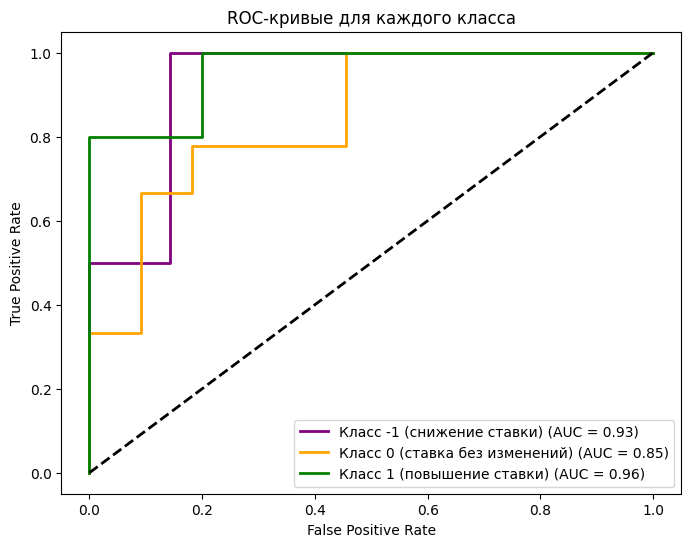

In [73]:
class_names = ['-1 (снижение ставки)', '0 (ставка без изменений)', '1 (повышение ставки)']

def evaluate(model, test_gen, class_names):
    y_true, y_pred = [], []
    # сбор всех предиктов и истинных меток
    for i in range(len(test_gen)):
        x,y = test_gen[i]
        y_true.extend(y)
        y_pred.extend(model.predict(x, verbose=0))
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    # !!! преобразуем метки для многоклассового ROC
    y_true_bin = label_binarize(y_true, classes=[0, 1, 2])
    # вычисляем ROC поклассово
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure(figsize=(8, 6))
    colors = ['purple', 'orange', 'green']
    for i, color, class_name in zip(range(3), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Класс {class_name} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривые для каждого класса')
    plt.legend()
    plt.show()

    # возвращаем метрики
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

    return accuracy, f1, np.mean(list(roc_auc.values())), roc_auc

accuracy, f1, macro_auc, auc_scores = evaluate(model, test_gen, class_names)

**! Важное отличие от линейных и нелинейных моделей заключается в том, что достигнуто более высокое значение метрики AUC для класса 0 (когда ставка не меняется).**

In [69]:
print(f"Accuracy: {accuracy:.3f}, F1-Score: {f1:.3f}, macro AUC: {macro_auc:.3f}, AUC в каждом классе: { {k: round(float(v), 3) for k, v in auc_scores.items()} }")

Accuracy: 0.750, F1-Score: 0.754, macro AUC: 0.912, AUC в каждом классе: {0: 0.929, 1: 0.848, 2: 0.96}


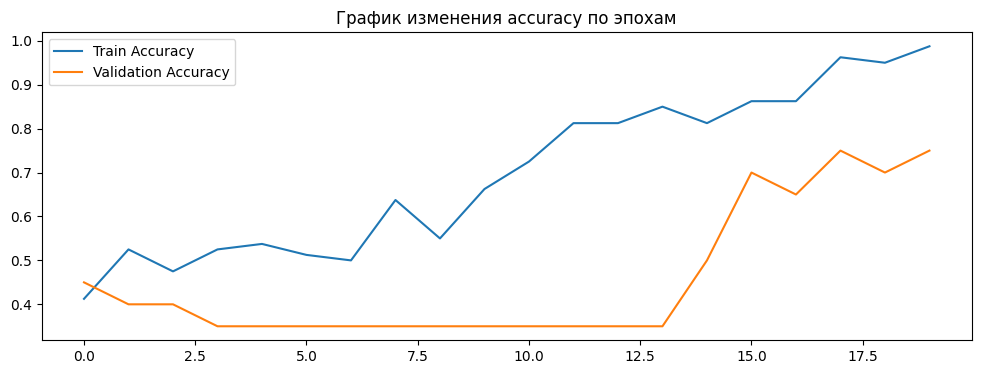

In [72]:
plt.figure(figsize=(12, 4))
plt.plot(teach.history['accuracy'], label='Train Accuracy')
plt.plot(teach.history['val_accuracy'], label='Validation Accuracy')
plt.title('График изменения accuracy по эпохам')
plt.legend()
plt.show()

**По графику видим, что по началу (до 13 эпохи) accuracy на валидации почти не менялась, и только с 13 эпохи начался стремительный рост данной метрики**

## Способ 2

In [79]:
EMBED_DIM = 128 # размерность векторного представления слов
NUM_HEADS = 4 # кол-во голов внимания в Transformer
FF_DIM = 64 # размер скрытого слоя в Feed Forward Network
EPOCHS = 20

**Архитектура трансформера:**
- используем [механизм внимания `MultiHeadAttention`](https://keras.io/api/layers/attention_layers/multi_head_attention/); если коротко, то это позволяет вычислить взвешенное среднее значений, где веса определяются на основе отношений между различными элементами входной последовательности;
- определяем двухслойную полносвязную сеть [Feed Forward Network](https://www.geeksforgeeks.org/feedforward-neural-network/);
- делаем нормализацию `LayerNormalization` + регуляризацию `Dropout`

Далее применяем [Self-Attention механизм](https://habr.com/ru/articles/781770/)

In [80]:
class GreatTransformer(layers.Layer):
    def __init__(self, emdim, num_of_heads, ff_dim):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_of_heads, key_dim=emdim)
        self.ffn = tf.keras.Sequential([layers.Dense(ff_dim, activation="relu"),layers.Dense(emdim)])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.1)
        self.dropout2 = layers.Dropout(0.1)

    def call(self, inputs, training=False):
        att_output = self.att(inputs, inputs)
        att_output = self.dropout1(att_output, training=training) # применяем dropout только во время обучения
        out1 = self.layernorm1(inputs + att_output)
        fn_output = self.ffn(out1)
        fn_output = self.dropout2(fn_output, training=training)
        return self.layernorm2(out1 + fn_output)

**Создание нейросетевой модели**

Архитектура модели:
- входной слой;
- слой эмбеддингов;
- слой Positional Encoding для сохранения информации о порядке слов в последовательности;
- слой кастомного трансформера `GreatTransformer` (его архитектура описана отдельно выше);
- слой `GlobalAveragePooling1D`;
- дропаут для регуляризации;
- выходной слой

In [81]:
def create_model_2(size, max_len):
    inputs = layers.Input(shape=(max_len,)) #создаём тензор формы (None, max_len)
    embedding = layers.Embedding(input_dim=size, output_dim=EMBED_DIM, input_length=max_len,mask_zero=True)(inputs) #добавляем слой эмбеддингов
    positions = tf.range(start=0, limit=max_len, delta=1) #добавляем positional encoding через слой эмбеддингов
    position_embedding = layers.Embedding(input_dim=max_len, output_dim=EMBED_DIM)(positions)
    x= embedding + position_embedding # сумма всех эмбеддингов
    x= GreatTransformer(EMBED_DIM, NUM_HEADS, FF_DIM)(x) # применяем блок трансформера
    x= layers.GlobalAveragePooling1D()(x) # преобразует (batch, seq_len, features) в (batch, features)
    x= layers.Dropout(0.3)(x) #регуляризируем

    outputs = layers.Dense(3, activation="softmax")(x) # выходной слой классификатора

    model = models.Model(inputs=inputs, outputs=outputs)

    optimizer = optimizers.AdamW(learning_rate=5e-5, weight_decay=1e-4) #оптимизатор AdamW

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [82]:
# токенизация с обработкой OOV-слов
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train) #преобразываем тексты в последовательности индексов
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN) #добавляем padding
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)
y_train_oh = tf.keras.utils.to_categorical(y_train, num_classes=3) # преобразованеи меток
y_test_oh = tf.keras.utils.to_categorical(y_test, num_classes=3)

In [83]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

In [84]:
model_2 = create_model_2(MAX_WORDS, MAX_LEN)

**Делаем обратные вызовы** (остановка при отстутствии изменений, сохранение лучшей модели, [динамическое уменьшение lr](https://keras.io/api/callbacks/reduce_lr_on_plateau/))

In [89]:
callbacks_list_2 = [
    callbacks.EarlyStopping(monitor='val_loss',patience=4, restore_best_weights=True, min_delta=0.001),
    callbacks.ModelCheckpoint('transformer_model.h5', save_best_only=True, monitor='val_accuracy'),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6
    )
]

**Обучение модели**

In [86]:
teach2 = model_2.fit(X_train_pad, y_train_oh, validation_data=(X_test_pad, y_test_oh), batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=callbacks_list, class_weight=class_weights)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.2859 - loss: 1.2013 - val_accuracy: 0.2500 - val_loss: 1.1646 - learning_rate: 5.0000e-05
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.2656 - loss: 1.1511 - val_accuracy: 0.2500 - val_loss: 1.1007 - learning_rate: 5.0000e-05
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.2906 - loss: 1.1477 - val_accuracy: 0.4500 - val_loss: 1.0689 - learning_rate: 5.0000e-05
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.3430 - loss: 1.0968 - val_accuracy: 0.5500 - val_loss: 1.0602 - learning_rate: 5.0000e-05
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - accuracy: 0.2883 - loss: 1.1296 - val_accuracy: 0.5000 - val_loss: 1.0598 - learning_rate: 5.0000e-05
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4219 - loss: 1.1107 - val_accuracy: 0.4000 - val_loss: 1.0615 - learning_rate: 5.0000e-05
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.3570 - loss: 1.1107 - val_acc

**Оцениваем результаты :)**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


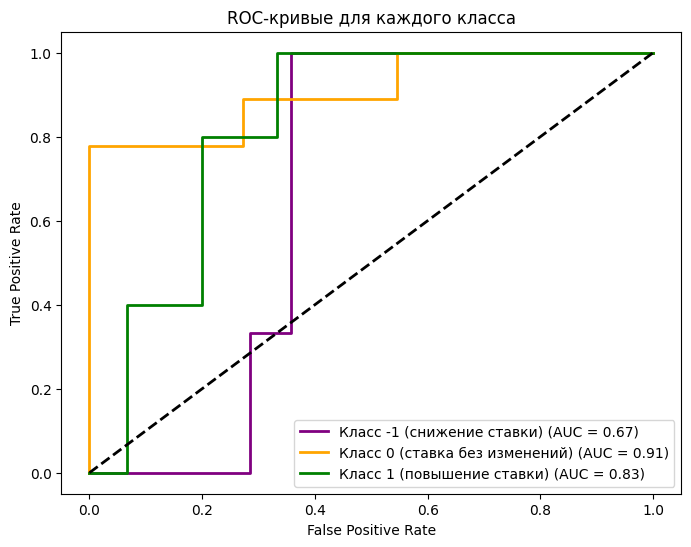

In [91]:
def evaluate_2(model, X_test, y_test):
    y_pred = model.predict(X_test) #получаем предикты
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    accuracy = accuracy_score(y_test_classes, y_pred_classes)
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    # бинаризация меток для roc-auc
    y_test_bin = label_binarize(y_test_classes, classes=[0, 1, 2])
    n_classes = y_test_bin.shape[1]
    # вычисляем ROC поклассово
    fpr, tpr, roc_auc = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(8, 6))
    colors = ['purple', 'orange', 'green']
    for i, color, class_name in zip(range(3), colors, class_names):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'Класс {class_name} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривые для каждого класса')
    plt.legend()
    plt.show()
    # вычисляем средний AUC
    macro_auc = np.mean(list(roc_auc.values()))

    return accuracy, f1, macro_auc, roc_auc

accuracy_2, f1_2, macro_auc_2, auc_scores_2 = evaluate_2(model_2, X_test_pad, y_test_oh)

**Удивительно, но наибольший AUC достигается именно для класса 0, который при использовании всех предыдущий моделей выходил с наименьшим AUC.**

In [92]:
print(f"Accuracy: {accuracy_2:.3f}, F1-Score: {f1_2:.3f}, macro AUC: {macro_auc_2:.3f}, AUC в каждом классе: { {k: round(float(v), 3) for k, v in auc_scores_2.items()} }")

Accuracy: 0.550, F1-Score: 0.493, macro AUC: 0.801, AUC в каждом классе: {0: 0.667, 1: 0.909, 2: 0.827}


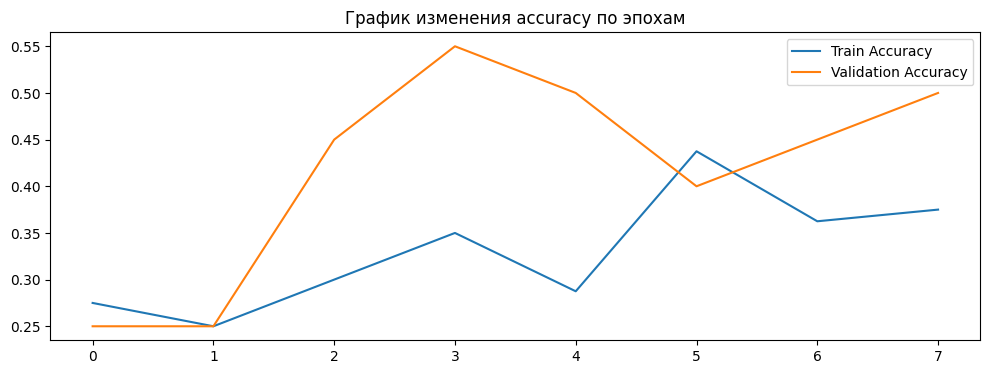

In [97]:
plt.figure(figsize=(12, 4))
plt.plot(teach2.history['accuracy'], label='Train Accuracy')
plt.plot(teach2.history['val_accuracy'], label='Validation Accuracy')
plt.title('График изменения accuracy по эпохам')
plt.legend()
plt.show()

**По графику видно, что обучение проводилось на 7 эпохах. Наибольшее качество на валидации было достигнуто не на последней эпохе, а на 3, однако разница незначительна**

# Общие выводы в результате построения DL-моделей
1. Лучшее качество (как по accuracy, так и по AUC) было достигнуто с использованием первой DL-модели (последовательная `Sequential` модель). Метрики в результате использования данной модели: Accuracy = 0.750, F1-Score = 0.754, macro AUC = 0.912, AUC в каждом классе = {0: 0.929, 1: 0.848, 2: 0.96}.
2. Вторая модель с кастомным трансформером имеет другую архитектуру, модель не `Sequential`. Несмотря на большую сложность, она показала качество, сопоставимое с линейными моделями. Метрики в результате использования данной модели: Accuracy = 0.550, F1-Score = 0.493, macro AUC = 0.801, AUC в каждом классе = {0: 0.667, 1: 0.909, 2: 0.827}